In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [10]:
df = pd.read_csv('features.csv', on_bad_lines='skip')
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nLabel distribution:")
print(df['label'].value_counts())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222104 entries, 0 to 222103
Data columns (total 49 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   client_id                222104 non-null  object 
 1   path                     222104 non-null  object 
 2   sentence                 222104 non-null  object 
 3   up_votes                 222104 non-null  int64  
 4   down_votes               222104 non-null  int64  
 5   age                      222104 non-null  object 
 6   gender                   222104 non-null  object 
 7   accent                   163422 non-null  object 
 8   label                    222104 non-null  int64  
 9   energy                   172158 non-null  float64
 10  entropy_of_energy        172158 non-null  float64
 11  tempo                    172158 non-null  float64
 12  rms_mean                 172158 non-null  float64
 13  rms_std                  172158 non-null  float64
 14  rms_

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,label,energy,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687170.mp3,He associated with the Formists.,2,1,fifties,female,us,3,0.001645,...,22.049347,17.756376,36.478886,7.216048,6.322589,2.029570,-2.271826,-0.899689,-3.445649,-4.229555
1,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687171.mp3,"The ""ultra accelerator"" injection gives Derric...",2,1,fifties,female,us,3,0.006090,...,34.444332,9.215692,-13.941004,4.038210,-9.090697,-12.068948,-3.776986,-3.775194,-0.427106,0.274453
2,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687172.mp3,"Despite running as a joke, candidates have won...",2,0,fifties,female,us,3,0.007691,...,6.307040,12.119217,-14.692726,0.590535,-5.350560,-13.934402,-2.036303,-7.696416,-9.105513,-1.700456
3,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687173.mp3,Stoner also guest-starred in the television dr...,2,0,fifties,female,us,3,0.010188,...,34.362572,12.479874,35.520008,14.594222,13.626840,-3.039428,-6.813199,-2.690670,-2.222628,-3.604904
4,5001d9a0d3f8f5aae6f386f70713b2d5d046edc7ba0068...,common_voice_en_19687174.mp3,Rainelle was named for the Raine family.,2,0,fifties,female,us,3,0.006867,...,26.035561,21.564060,26.624199,10.622624,7.874703,2.720687,-8.067606,2.597533,0.322957,-10.668774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222099,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_19246427.mp3,We had dancers in the old days.,2,0,twenties,male,NaN,0,0.002220,...,14.600637,-0.518237,2.797074,-10.886346,0.275344,-1.149006,-6.698080,-4.911278,-6.481758,0.001764
222100,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_19261735.mp3,The taxonomic arrangement presented below is b...,2,0,twenties,male,NaN,0,0.002906,...,13.416354,15.975633,11.616440,-9.070229,4.966941,0.553191,-6.471150,2.454182,-4.776167,-3.428197
222101,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_19267150.mp3,Both of the converted ships saw action.,2,0,twenties,male,NaN,0,0.004863,...,5.603609,3.918690,3.999201,-8.417794,3.788709,0.563152,-5.002996,2.073364,-0.745641,-1.306939
222102,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_19267152.mp3,The Robert Hooke Science Centre is further awa...,2,1,twenties,male,NaN,0,0.009213,...,8.343183,-2.639572,4.442166,-13.847738,2.917359,-8.589788,-12.978580,-1.195083,-5.442918,-4.915794


In [11]:
df_clean = df.dropna(subset=['energy'], how='all')

print(f"Original shape: {df.shape}, Cleaned shape: {df_clean.shape}")

Original shape: (222104, 49), Cleaned shape: (172158, 49)


In [12]:
# Calculate signal-to-noise ratio (approximation)
df_clean['snr'] = df_clean['rms_mean'] / (df_clean['rms_std'] + 1e-10)

# Create a "vocal range" feature
df_clean['vocal_range'] = df_clean['pitch_max'] - df_clean['pitch_min']

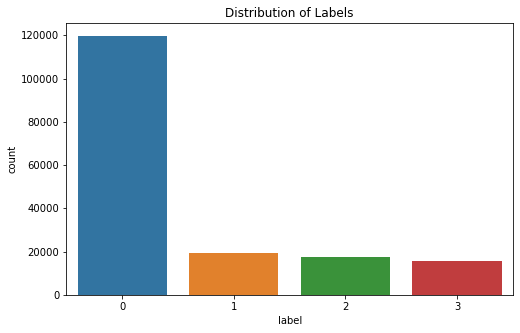

In [13]:
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=df_clean)
plt.title('Distribution of Labels')
plt.show()

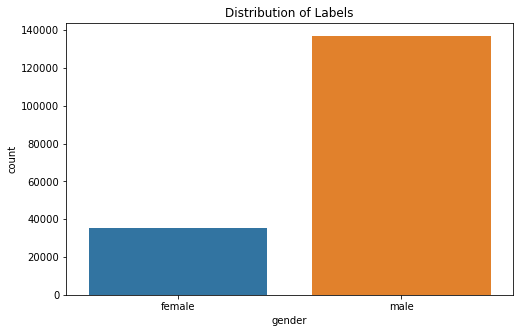

In [14]:
plt.figure(figsize=(8,5))
sns.countplot(x='gender', data=df_clean)
plt.title('Distribution of Labels')
plt.show()

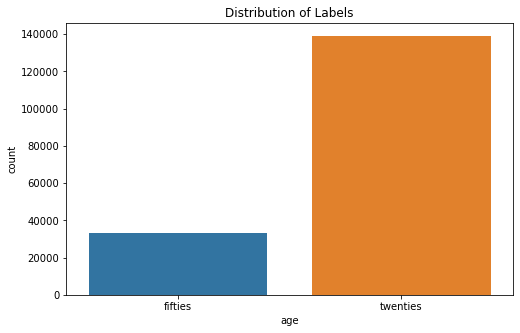

In [15]:
plt.figure(figsize=(8,5))
sns.countplot(x='age', data=df_clean)
plt.title('Distribution of Labels')
plt.show()

In [16]:
import pandas as pd
from sklearn.utils import resample

# Make a copy of the original dataframe
df_balanced = df_clean.copy()
#TODO IS BALANCING OTHER FEATURES NECESSARY ?? (E.G. GENDER , AGE)
# 1. Balance 'label' categories
df_majority_1 = df_clean[df_clean.label == 0]
df_class_1 = df_clean[df_clean.label == 1]
df_class_2 = df_clean[df_clean.label == 2]
df_class_3 = df_clean[df_clean.label == 3]

n_samples_1 = len(df_majority_1)

# Upsample minority classes for 'label'
df_class_1_upsampled = resample(df_class_1, replace=True, n_samples=n_samples_1, random_state=42)
df_class_2_upsampled = resample(df_class_2, replace=True, n_samples=n_samples_1, random_state=42)
df_class_3_upsampled = resample(df_class_3, replace=True, n_samples=n_samples_1, random_state=42)

# Create balanced dataframe for 'label'
df_label_balanced = pd.concat([df_majority_1, df_class_1_upsampled, df_class_2_upsampled, df_class_3_upsampled])

# 2. Balance 'gender' categories
df_majority_2 = df_label_balanced[df_label_balanced.gender == "male"]
df_class_5 = df_label_balanced[df_label_balanced.gender == 'female']

n_samples_2 = max(len(df_majority_2), len(df_class_5))

# Upsample minority class for 'gender'
if len(df_majority_2) < len(df_class_5):
    df_majority_2 = resample(df_majority_2, replace=True, n_samples=n_samples_2, random_state=42)
else:
    df_class_5_upsampled = resample(df_class_5, replace=True, n_samples=n_samples_2, random_state=42)

# Create balanced dataframe for 'gender'
df_gender_balanced = pd.concat([df_majority_2, df_class_5_upsampled if len(df_majority_2) >= len(df_class_5) else df_class_5])

# 3. Balance 'age' categories
df_majority_3 = df_gender_balanced[df_gender_balanced.age == "twenties"]
df_class_7 = df_gender_balanced[df_gender_balanced.age == 'fifties']

n_samples_3 = max(len(df_majority_3), len(df_class_7))

# Upsample minority class for 'age'
if len(df_majority_3) < len(df_class_7):
    df_majority_3 = resample(df_majority_3, replace=True, n_samples=n_samples_3, random_state=42)
else:
    df_class_7_upsampled = resample(df_class_7, replace=True, n_samples=n_samples_3, random_state=42)

# Create final balanced dataframe
df_clean = pd.concat([df_majority_3, df_class_7_upsampled if len(df_majority_3) >= len(df_class_7) else df_class_7])

# Shuffle the dataset
df_clean = df_clean.sample(frac=1, random_state=42).reset_index(drop=True)

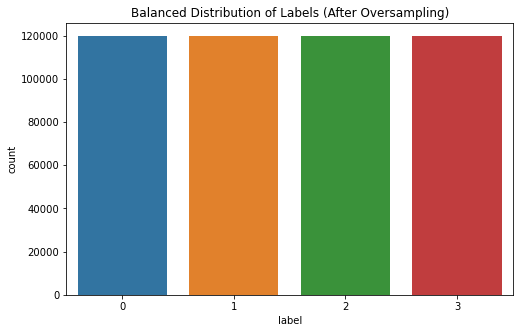

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(x='label', data=df_clean)
plt.title('Balanced Distribution of Labels (After Oversampling)')
plt.show()


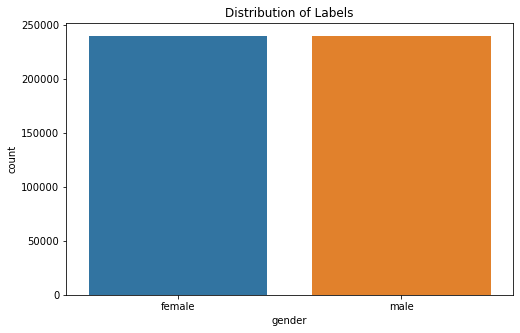

In [18]:
plt.figure(figsize=(8,5))
sns.countplot(x='gender', data=df_clean)
plt.title('Distribution of Labels')
plt.show()

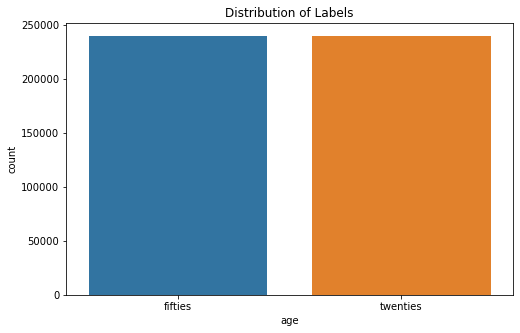

In [19]:
plt.figure(figsize=(8,5))
sns.countplot(x='age', data=df_clean)
plt.title('Distribution of Labels')
plt.show()

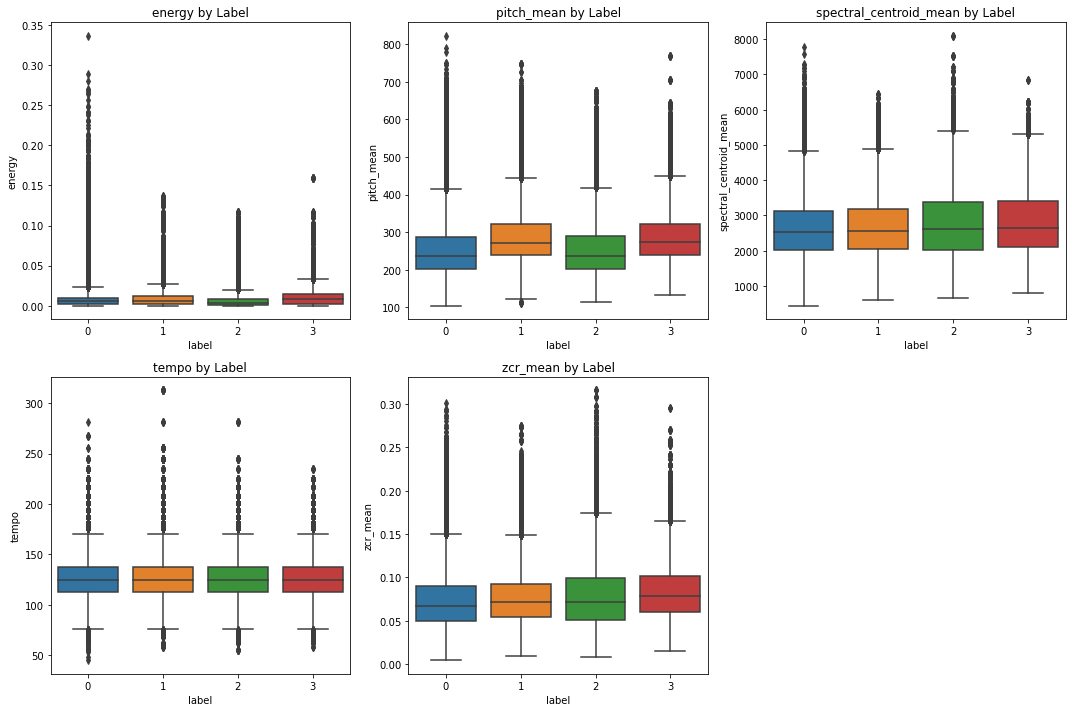

In [20]:
features_to_plot = ['energy', 'pitch_mean', 'spectral_centroid_mean', 'tempo', 'zcr_mean']

plt.figure(figsize=(15,10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='label', y=feature, data=df_clean)
    plt.title(f'{feature} by Label')
plt.tight_layout()
plt.show()

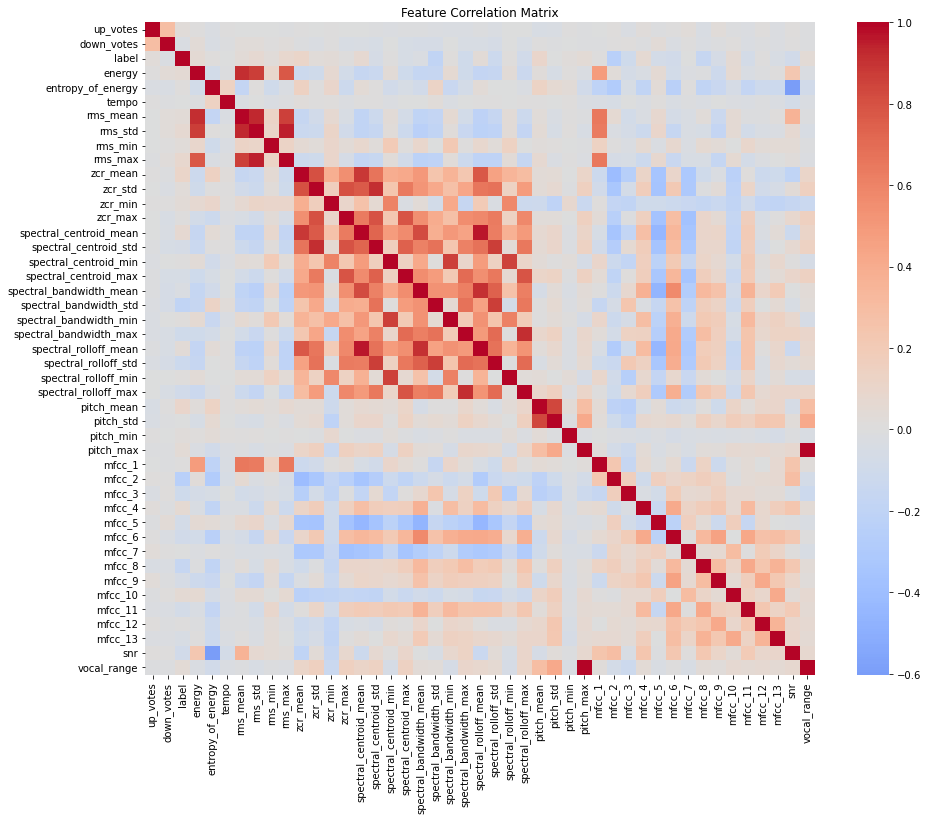

In [21]:
# Calculate correlation matrix
corr_matrix = df_clean.select_dtypes(include=[np.number]).corr()

# Plot heatmap
plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

In [22]:
selected_features = [
    'pitch_mean',
    'pitch_std',
    'spectral_centroid_mean',
    'spectral_bandwidth_mean',
    'spectral_rolloff_mean',
    'energy'
    # 'mfcc_1','mfcc_2','mfcc_3','mfcc_4','mfcc_5','mfcc_6','mfcc_7','mfcc_8','mfcc_9','mfcc_10','mfcc_11','mfcc_12','mfcc_13'
]

demographic_features = ['age', 'gender']

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separate features and target
X = df_clean[selected_features + demographic_features]
y = df_clean['label']

#X_train -->gender , age
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


# # Preprocessing pipeline
# numeric_features = selected_features
# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())])

# categorical_features = demographic_features
# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)])

# print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
# print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
# X.head()


In [24]:
from sklearn.ensemble import RandomForestClassifier

# Prepare data (using only audio features)
gender_features = X_train.drop(['age', 'gender'], axis=1)
gender_target = X_train['gender']
standard_scaler=StandardScaler()
scaled_gender_features=standard_scaler.fit_transform(gender_features)
# Train/test split
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(
    scaled_gender_features, gender_target, test_size=0.3, random_state=42)

# Train model
gender_model = RandomForestClassifier()
gender_model.fit(X_train_gender, y_train_gender)

# Evaluate
print("Gender Accuracy:", gender_model.score(X_test_gender, y_test_gender))

Gender Accuracy: 0.9630738026824686


In [25]:
age_features = X_train.drop(['age', 'gender'], axis=1)
age_target = X_train['age']
standard_scaler=StandardScaler()
scaled_age_features=standard_scaler.fit_transform(age_features)
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
    age_features, age_target, test_size=0.3, random_state=42)

age_model = RandomForestClassifier()
age_model.fit(X_train_age, y_train_age)

print("Age Accuracy:", age_model.score(X_test_age, y_test_age))

Age Accuracy: 0.9630738026824686


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split data
X = df_clean[selected_features + demographic_features]
y = df_clean['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# ==============================================
# STEP 1: Train Demographic Predictors (Gender/Age)
# ==============================================

# Gender prediction model (using only audio features)
X_train_gender = X_train[selected_features]
y_train_gender = X_train['gender']

gender_model = RandomForestClassifier(random_state=42,n_estimators=200)
gender_model.fit(X_train_gender, y_train_gender)

# Age prediction model (using only audio features)
X_train_age = X_train[selected_features]
y_train_age = X_train['age']

age_model = RandomForestClassifier(random_state=42,n_estimators=200)
age_model.fit(X_train_age, y_train_age)

# Evaluate demographic models
print("=== Gender Model Evaluation ===")
print("Training Accuracy:")
print(classification_report(y_train_gender, gender_model.predict(X_train_gender)))
print("\nTest Accuracy:")
print(classification_report(X_test['gender'], gender_model.predict(X_test[selected_features])))

print("\n=== Age Model Evaluation ===")
print("Training Accuracy:")
print(classification_report(y_train_age, age_model.predict(X_train_age)))
print("\nTest Accuracy:")
print(classification_report(X_test['age'], age_model.predict(X_test[selected_features])))

# ==============================================
# STEP 2: Apply Optimized Conditional Logic
# ==============================================

# Predict demographics for the entire test set at once
X_test_features = X_test[selected_features]
pred_genders = gender_model.predict(X_test_features)
pred_ages = age_model.predict(X_test_features)

# Also predict for training set
train_pred_genders = gender_model.predict(X_train[selected_features])
train_pred_ages = age_model.predict(X_train[selected_features])

print("\nUnique values in pred_genders:", np.unique(pred_genders))
print("Unique values in pred_ages:", np.unique(pred_ages))

# Initialize prediction arrays
y_pred_test = np.zeros(len(X_test), dtype=int)
y_pred_train = np.zeros(len(X_train), dtype=int)

# Set values based on conditions (using string values)
# For test set
y_pred_test[(pred_genders == 'male') & (pred_ages == 'twenties')] = 0
y_pred_test[(pred_genders == 'female') & (pred_ages == 'twenties')] = 1
y_pred_test[(pred_genders == 'male') & (pred_ages == 'fifties')] = 2
y_pred_test[(pred_genders == 'female') & (pred_ages == 'fifties')] = 3

# For training set
y_pred_train[(train_pred_genders == 'male') & (train_pred_ages == 'twenties')] = 0
y_pred_train[(train_pred_genders == 'female') & (train_pred_ages == 'twenties')] = 1
y_pred_train[(train_pred_genders == 'male') & (train_pred_ages == 'fifties')] = 2
y_pred_train[(train_pred_genders == 'female') & (train_pred_ages == 'fifties')] = 3

# Evaluate conditional logic approach
print("\n=== Conditional Logic Model Evaluation ===")
print("Training Accuracy:")
print(classification_report(y_train, y_pred_train))
print("\nTest Accuracy:")
print(classification_report(y_test, y_pred_test))

# ==============================================
# STEP 3: Prediction Function
# ==============================================

def predict_label(audio_features):
    """Predict label from audio features using conditional logic pipeline"""
    # Convert to DataFrame if needed
    if not isinstance(audio_features, pd.DataFrame):
        audio_features = pd.DataFrame([audio_features], columns=selected_features)

    # Predict demographics for all samples at once
    pred_gender = gender_model.predict(audio_features)
    pred_age = age_model.predict(audio_features)

    # Apply conditional logic using NumPy (vectorized approach)
    result = np.zeros(len(audio_features), dtype=int)
    result[(pred_gender == 'male') & (pred_age == 'twenties')] = 0
    result[(pred_gender == 'female') & (pred_age == 'twenties')] = 1
    result[(pred_gender == 'male') & (pred_age == 'fifties')] = 2
    result[(pred_gender == 'female') & (pred_age == 'fifties')] = 3
    
    # If called with a single sample, return a scalar instead of array
    if len(result) == 1:
        return result[0]
    return result

=== Gender Model Evaluation ===
Training Accuracy:
              precision    recall  f1-score   support

      female       1.00      1.00      1.00    167579
        male       1.00      1.00      1.00    167683

    accuracy                           1.00    335262
   macro avg       1.00      1.00      1.00    335262
weighted avg       1.00      1.00      1.00    335262


Test Accuracy:
              precision    recall  f1-score   support

      female       0.96      0.99      0.97     71820
        male       0.99      0.96      0.97     71864

    accuracy                           0.97    143684
   macro avg       0.98      0.97      0.97    143684
weighted avg       0.98      0.97      0.97    143684


=== Age Model Evaluation ===
Training Accuracy:
              precision    recall  f1-score   support

     fifties       1.00      1.00      1.00    167631
    twenties       1.00      1.00      1.00    167631

    accuracy                           1.00    335262
   macro avg

SVC,KNN
Data cleaning 
Gridsearch on parameters
Cross Validation

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split data
X = df_clean[selected_features + demographic_features]
y = df_clean['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# ==============================================
# STEP 1: Train Demographic Predictors (Gender/Age)
# ==============================================

# Gender prediction model (using only audio features)
X_train_gender = X_train[selected_features]
y_train_gender = X_train['gender']

standard_scaler=StandardScaler()
scaled_X_train_gender=standard_scaler.fit_transform(X_train_gender)

gender_model = RandomForestClassifier(random_state=42)
gender_model.fit(scaled_X_train_gender, y_train_gender)

# Age prediction model (using only audio features)
X_train_age = X_train[selected_features]
y_train_age = X_train['age']
scaled_X_train_age=standard_scaler.fit_transform(X_train_age)

age_model = RandomForestClassifier(random_state=42)
age_model.fit(scaled_X_train_age, y_train_age)

# Evaluate demographic models
print("=== Gender Model Evaluation ===")
X_test_gender = X_test[selected_features]
standard_scaler=StandardScaler()
scaled_X_test_gender=standard_scaler.fit_transform(X_test_gender)
print(classification_report(X_test['gender'], gender_model.predict(scaled_X_test_gender)))

print("\n=== Age Model Evaluation ===")
X_test_age = X_test[selected_features]
standard_scaler=StandardScaler()
scaled_X_test_age=standard_scaler.fit_transform(X_test_age)
print(classification_report(X_test['age'], age_model.predict(scaled_X_test_age)))

# ==============================================
# STEP 2: Apply Optimized Conditional Logic
# ==============================================

# Predict demographics for the entire test set at once
X_test_features = X_test[selected_features]
pred_genders = gender_model.predict(X_test_features)
pred_ages = age_model.predict(X_test_features)
print("Unique values in pred_genders:", np.unique(pred_genders))
print("Unique values in pred_ages:", np.unique(pred_ages))

# Initialize prediction array
y_pred = np.zeros(len(X_test), dtype=int)

# Set values based on conditions (using string values)
y_pred[(pred_genders == 'male') & (pred_ages == 'twenties')] = 0
y_pred[(pred_genders == 'female') & (pred_ages == 'twenties')] = 1
y_pred[(pred_genders == 'male') & (pred_ages == 'fifties')] = 2
y_pred[(pred_genders == 'female') & (pred_ages == 'fifties')] = 3

# Evaluate conditional logic approach
print("\n=== Conditional Logic Model Evaluation ===")
print(classification_report(y_test, y_pred))

# ==============================================
# STEP 3: Prediction Function
# ==============================================

def predict_label(audio_features):
    """Predict label from audio features using conditional logic pipeline"""
    # Convert to DataFrame if needed
    if not isinstance(audio_features, pd.DataFrame):
        audio_features = pd.DataFrame([audio_features], columns=selected_features)

    # Predict demographics for all samples at once
    pred_gender = gender_model.predict(audio_features)
    pred_age = age_model.predict(audio_features)

    # Apply conditional logic using NumPy (vectorized approach)
    result = np.zeros(len(audio_features), dtype=int)
    result[(pred_genders == 'male') & (pred_ages == 'twenties')] = 0
    result[(pred_genders == 'female') & (pred_ages == 'twenties')] = 1
    result[(pred_genders == 'male') & (pred_ages == 'fifties')] = 2
    result[(pred_genders == 'female') & (pred_ages == 'fifties')] = 3
    
    # If called with a single sample, return a scalar instead of array
    if len(result) == 1:
        return result[0]
    return result

=== Gender Model Evaluation ===
              precision    recall  f1-score   support

      female       0.95      0.98      0.97     71820
        male       0.98      0.95      0.97     71864

    accuracy                           0.97    143684
   macro avg       0.97      0.97      0.97    143684
weighted avg       0.97      0.97      0.97    143684


=== Age Model Evaluation ===
              precision    recall  f1-score   support

     fifties       0.97      0.98      0.97     71842
    twenties       0.98      0.97      0.97     71842

    accuracy                           0.97    143684
   macro avg       0.97      0.97      0.97    143684
weighted avg       0.97      0.97      0.97    143684

Unique values in pred_genders: ['male']
Unique values in pred_ages: ['twenties']

=== Conditional Logic Model Evaluation ===
              precision    recall  f1-score   support

           0       0.25      1.00      0.40     35910
           1       0.00      0.00      0.00     35